In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

<h1> Projection Methods

In [2]:
np.random.seed(4)
m = 200
w1,w2 = 0.3,0.5
noise = 0.2

angles = np.random.rand(m)*3*np.pi / 2 - 0.5
X = np.empty((m,3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


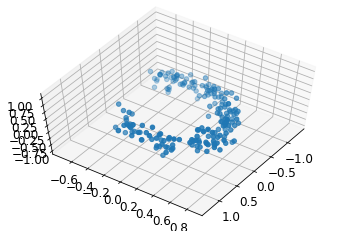

In [3]:
from mpl_toolkits import mplot3d
fig = plt.axes()
ax = plt.axes(projection ='3d')
ax.scatter3D(X[:,0], X[:,1],X[:,2], cmap='Greens')
ax.view_init(60, 35)

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))


True

In [7]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D


<h1> Now try using sckit-learn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]


array([[ 1.5184339 ,  0.52896172],
       [-0.43713052, -0.61316111],
       [ 1.54916728,  0.39523111],
       [ 0.86667185, -0.24871059],
       [ 0.81273562, -0.26601357]])

In [10]:
X2D_using_svd[:5]

array([[-1.5184339 , -0.52896172],
       [ 0.43713052,  0.61316111],
       [-1.54916728, -0.39523111],
       [-0.86667185,  0.24871059],
       [-0.81273562,  0.26601357]])

Running PCA multiple times on slightly diffetent datasets may reult in different reults. THe only differens ice the some axes may be flipped. In this example, PCA using sckite leanr gives the same projcetion s the one givne by the SVD appraoch,excpe tboth axes are flipped.

In [11]:
np.allclose(X2D, X2D_using_svd)

False

In [12]:
#recover the 3d points projcted on the plane(PCA 2d)
X3D_inv = pca.inverse_transform(X2D)

In [13]:
np.allclose(X3D_inv,X)

False

In [14]:
X3D_inv[:10]


array([[-1.07073875, -0.69624477, -0.71680012],
       [ 0.09099749,  0.83092214,  0.48603272],
       [-1.15675559, -0.59354385, -0.68710099],
       [-0.86090638,  0.144377  , -0.18869654],
       [-0.82252215,  0.17463791, -0.16007071],
       [ 1.03312745,  0.54320343,  0.62149545],
       [-0.93294787, -0.60824938, -0.62539666],
       [ 0.58779753, -0.28088663,  0.02904697],
       [ 1.12170435,  0.47037791,  0.60903763],
       [ 0.32913055,  0.7737528 ,  0.52883327]])

In [15]:
X.shape

(200, 3)

In [16]:
#try computing the reoncstruction error
#sum for i observations
np.mean(np.sum(np.square(X3D_inv - X),axis=1))

0.02784637906069176

The inverse transform using SVD looks like:

In [17]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconsturctions from both methods are not dientical ebcause skleanrs PCA class automatically tkes care of reverseing the mean centering, but uf we subtract the mean, we get the same reconstruction

In [18]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)


True

In [19]:
pca.components_

array([[-0.85497065, -0.29307481, -0.42793966],
       [ 0.44672422, -0.83532193, -0.320429  ]])

In [20]:
Vt[:2]

array([[ 0.85497065,  0.29307481,  0.42793966],
       [-0.44672422,  0.83532193,  0.320429  ]])

In [21]:
pca.explained_variance_ratio_

array([0.8549864 , 0.12058722])

In [22]:
1 - pca.explained_variance_ratio_.sum()

0.02442638391606533

In [23]:
np.square(s) / np.square(s).sum()

array([0.8549864 , 0.12058722, 0.02442638])

Let's draw some nice figures

In [24]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

#define class to patch arrows
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [25]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

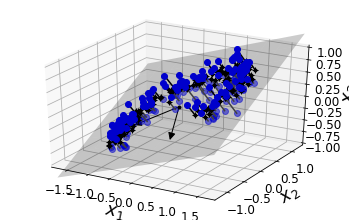

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

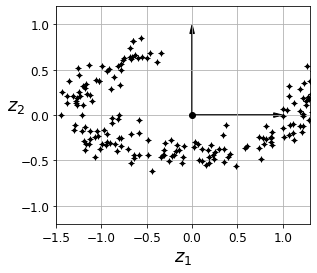

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

<h1> Manifold Learning

In [28]:
from sklearn.datasets import make_swiss_roll
X,t = make_swiss_roll(n_samples=2000,noise=0.3,random_state=42)

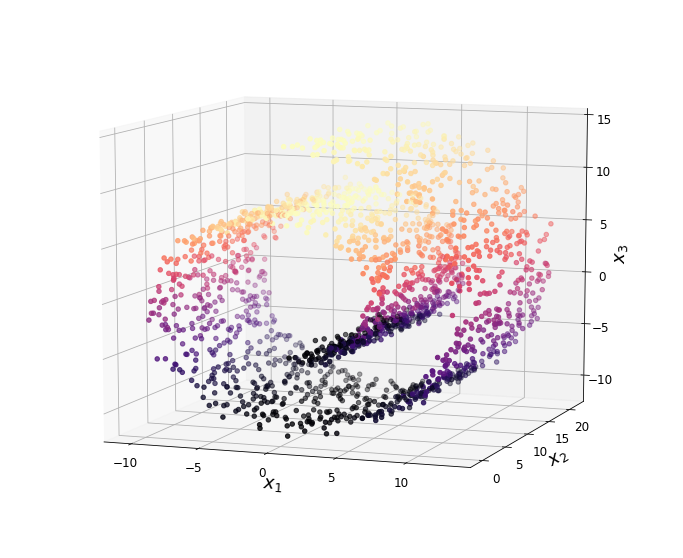

In [29]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.sin(t), cmap=plt.cm.magma)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

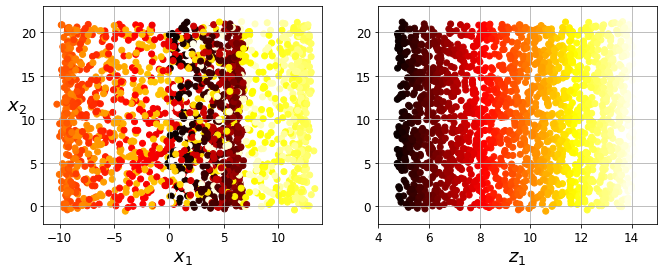

In [30]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

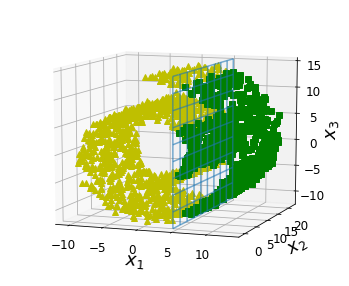

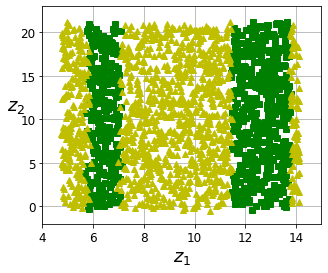

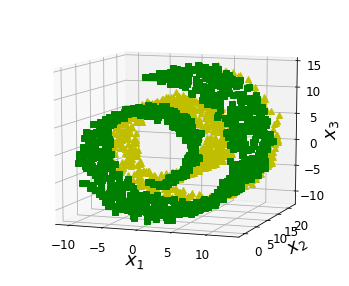

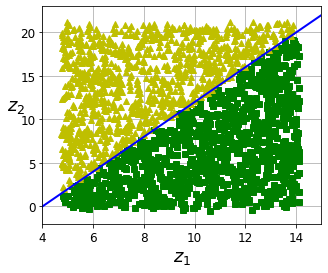

In [32]:
from matplotlib import gridspec

from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.6)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

<h1> PCA

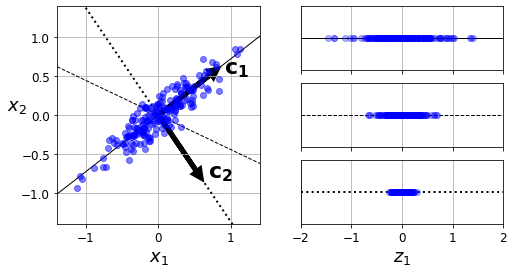

In [33]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()


<h1> MNIST compression

In [200]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [201]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [36]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [37]:
d

154

In [38]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [39]:
pca.n_components_

154

In [40]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

In [41]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [42]:
print(X_reduced.shape)
print(X_recovered.shape)

(52500, 154)
(52500, 784)


In [43]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

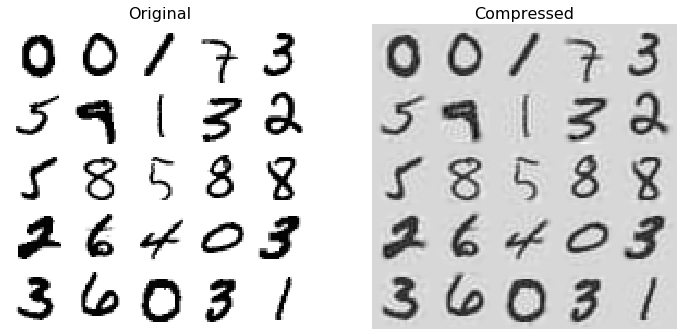

In [44]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [45]:
X_reduced_pca = X_reduced

<h1> Incremental PCA

In [46]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [47]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

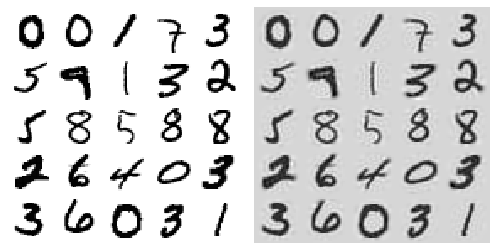

In [48]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [49]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transofmring MNIST using regular PCA and iPCA. First, the means are equal:

In [50]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [51]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

Let's create the memmap structire and copy the MNIST data into it. This would typically done first by a program.

In [52]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm = X_train

In [53]:
X_mm.shape

(52500, 784)

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk

In [54]:
del X_mm

In [55]:
#another program would load the data and use it for training
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [56]:
rnd_pca = PCA(n_components=154,svd_solver='randomized',random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

<h1> Time complexity</h1> 
lets time regulard PCA against incremental PCA and Randomized PCA for various number of prinicpal compnents

In [57]:
import time
for n_components in (2,5,10,25,75,100,154):
    print("n_comps = ", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")
    
    for pca in (regular_pca,inc_pca,rnd_pca):
        #get start time
        t1 = time.time()
        pca.fit(X_train)
        #end time
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))
        
        
    
    

n_comps =  2
    PCA: 1.7 seconds
    IncrementalPCA: 13.5 seconds
    PCA: 1.7 seconds
n_comps =  5
    PCA: 1.7 seconds
    IncrementalPCA: 14.3 seconds
    PCA: 1.7 seconds
n_comps =  10
    PCA: 1.7 seconds
    IncrementalPCA: 15.0 seconds
    PCA: 1.8 seconds
n_comps =  25
    PCA: 2.3 seconds
    IncrementalPCA: 15.1 seconds
    PCA: 2.4 seconds
n_comps =  75
    PCA: 3.5 seconds
    IncrementalPCA: 15.9 seconds
    PCA: 3.4 seconds
n_comps =  100
    PCA: 3.1 seconds
    IncrementalPCA: 16.0 seconds
    PCA: 3.0 seconds
n_comps =  154
    PCA: 3.8 seconds
    IncrementalPCA: 21.5 seconds
    PCA: 3.8 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

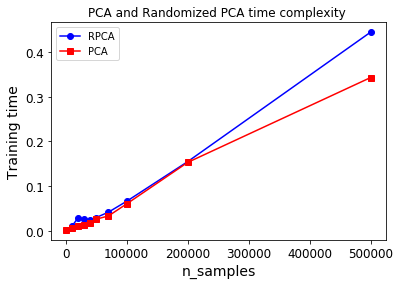

In [199]:
#now lets compare PCA and Randomized PCA for datasets of different sizes


times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
    


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

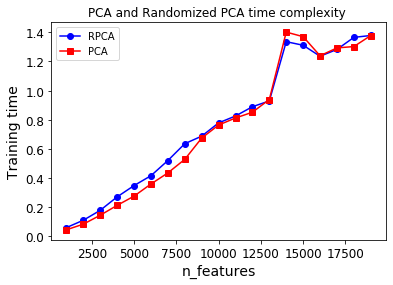

In [205]:
#now lets compare their performance on datasets of 2,000 instanaces
#with different numbers of features
times_rpca = []
times_pca = []
sizes = [i*1000 for i in range(1,20)]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

<h1> Kernel PCA

In [209]:
X, t = make_swiss_roll(n_samples=5000, noise=0.3, random_state=42)


In [210]:
from sklearn.decomposition import KernelPCA
#using rbf kernel
#make sure to play around with the gamma
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.05)
X_reduced = rbf_pca.fit_transform(X)


<Figure size 864x864 with 0 Axes>

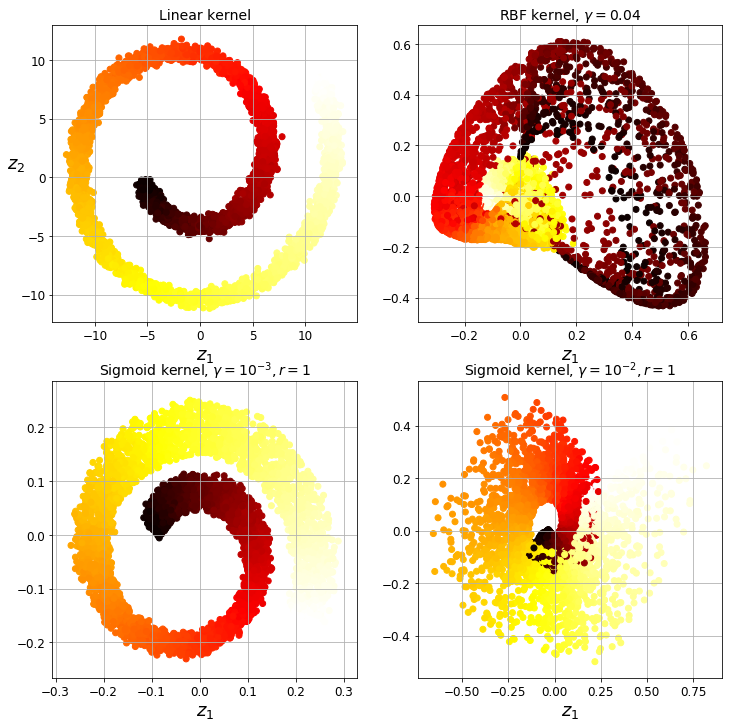

In [215]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
sig_pca2 = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.01, coef0=2, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(12,12))
plt.figure(figsize=(12, 12))
for subplot, pca, title in ((221, lin_pca, "Linear kernel"), 
                            (222, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (223, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"),
                           (224, sig_pca2,"Sigmoid kernel, $\gamma=10^{-2}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 221:
        plt.ylabel("$z_2$", fontsize = 18, rotation=0)
    plt.grid(True)

plt.show()





(array([525., 504., 501., 503., 466., 500., 531., 468., 522., 480.]),
 array([ 4.71249864,  5.65469938,  6.59690012,  7.53910087,  8.48130161,
         9.42350235, 10.3657031 , 11.30790384, 12.25010459, 13.19230533,
        14.13450607]),
 <a list of 10 Patch objects>)

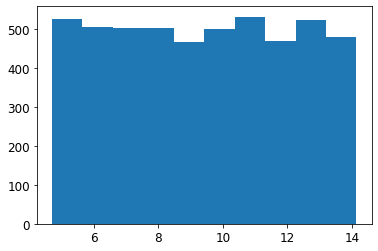

In [212]:
plt.figure(figsize=(6,5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

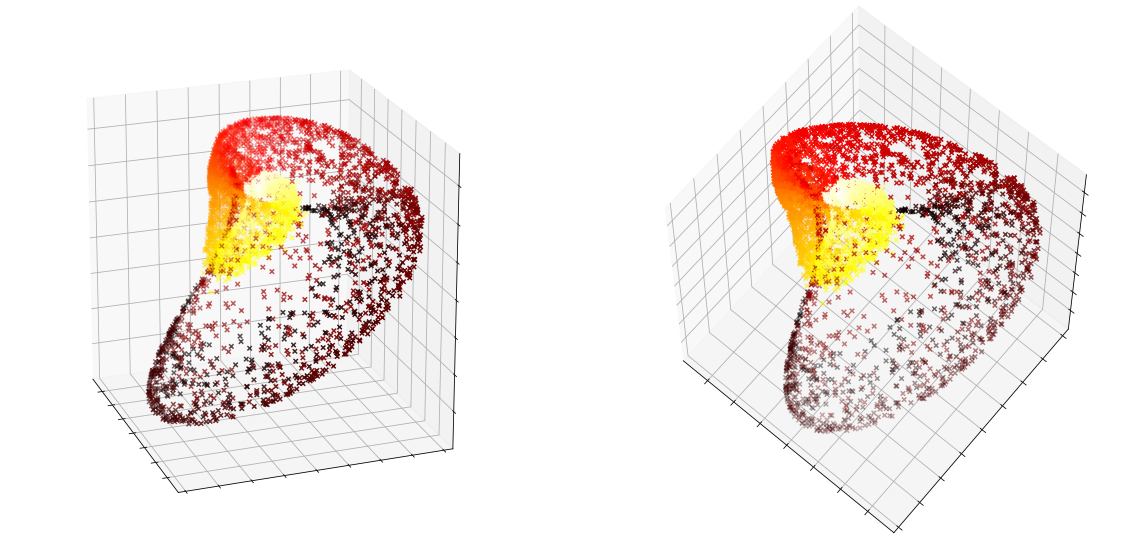

In [225]:
plt.figure(figsize=(20, 10))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(121, projection='3d')
ax.view_init(20, -20)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax = plt.subplot(122, projection='3d')
ax.view_init(60, -50)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

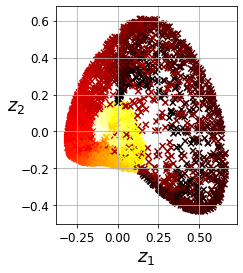

In [228]:
X_reduced = rbf_pca.fit_transform(X)
plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [230]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca',KernelPCA(n_components=2)),
    ("log_reg",LogisticRegression(solver='liblinear'))
])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [234]:
pd.DataFrame(grid_search.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.892170      0.077361         0.086495        0.007725   
1       0.712342      0.004654         0.099390        0.001364   
2       0.789283      0.005090         0.081272        0.000230   
3       0.706517      0.005108         0.098441        0.000817   
4       0.792868      0.007748         0.081195        0.001050   

  param_kpca__gamma param_kpca__kernel  \
0              0.03                rbf   
1              0.03            sigmoid   
2         0.0322222                rbf   
3         0.0322222            sigmoid   
4         0.0344444                rbf   

                                              params  split0_test_score  \
0       {'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}           0.913087   
1   {'kpca__gamma': 0.03, 'kpca__kernel': 'sigmoid'}           0.740260   
2  {'kpca__gamma': 0.03222222222222222, 'kpca__ke...           0.925075   
3  {'kpca__gamma': 0.03222222222222222, 'kpca__ke...           0.738262   
4  {'kpca__gamma': 0.034444444444444444, 'kpca__k...           0.931069   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0              0.916              0.909              0.923           0.928929   
1              0.743              0.740              0.742           0.745746   
2              0.928              0.921              0.928           0.935936   
3              0.742              0.740              0.741           0.745746   
4              0.936              0.926              0.930           0.939940   

   mean_test_score  std_test_score  rank_test_score  
0           0.9180        0.007120               10  
1           0.7422        0.002090               11  
2           0.9276        0.004892                9  
3           0.7414        0.002498               12  
4           0.9326        0.004859                8

In [235]:
grid_search.best_params_

{'kpca__gamma': 0.05, 'kpca__kernel': 'rbf'}

In [239]:
rbf_pca = KernelPCA(n_components=2,kernel='rbf',gamma=0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

In [242]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [244]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

30.810622036613

<h1> LLE

In [245]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [246]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2,n_neighbors=10,
                            random_state=42)
X_reduced = lle.fit_transform(X)

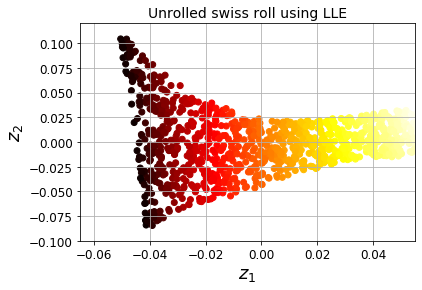

In [247]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

<h1> MDS, Isomap, tsne

In [249]:
from sklearn.manifold import MDS,Isomap,TSNE

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [251]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


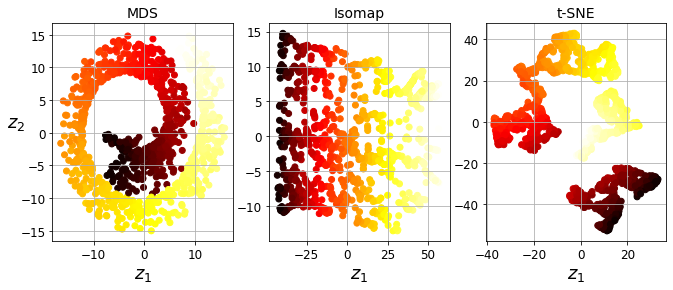

In [253]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()


In [254]:
def learned_parameters(model):
    return [m for m in dir(model)
            if m.endswith("_") and not m.startswith("_")]

In [258]:
learned_parameters(mds)

['dissimilarity_matrix_', 'embedding_', 'n_iter_', 'stress_']

In [262]:
mds.embedding_

array([[  9.73196515,   1.42160731],
       [ -3.6475494 ,  -5.7211426 ],
       [-11.53904167, -10.76777733],
       ...,
       [ 14.81580818,   8.05027517],
       [  1.85460097,  -2.23742471],
       [ 11.68555708,   2.15187306]])

<h1> Extra Material - Clustering </h1>
<h3> Introduction - Classification vs Clustering </h3>

In [264]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

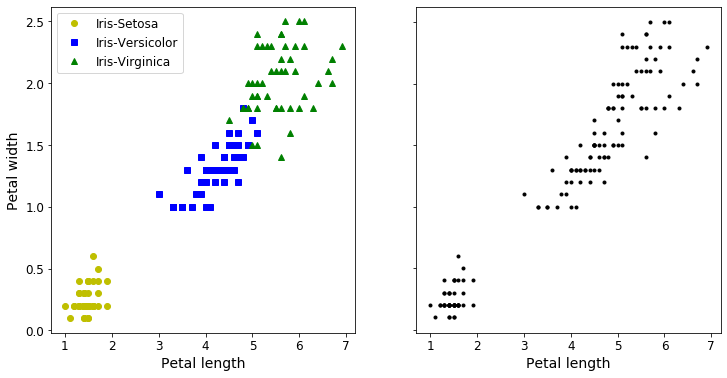

In [270]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A gaussian mixture model (explained below) can actually sepearte these cluster pretty well. Using all 4 features, petal length and width, and speal length and width

In [285]:
from sklearn.mixture import GaussianMixture
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2,0,1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])




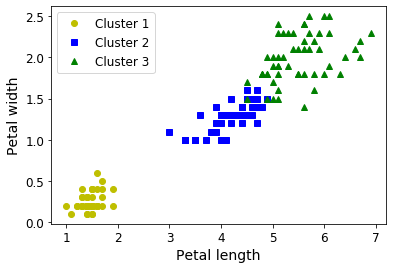

In [290]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [291]:
np.sum(y_pred==y)

145

In [292]:
np.sum(y_pred == y) / len(y_pred)

0.9666666666666667

<h1> Compared to kmeans

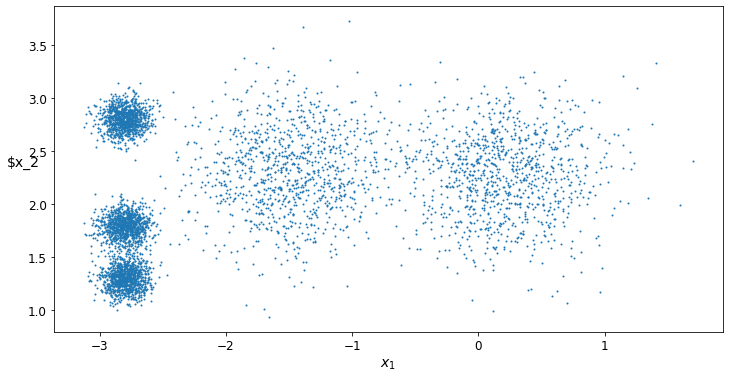

In [2]:
from sklearn.datasets import make_blobs
blob_centers = np.array(
    [[0.2,2.3],
    [-1.5,2.3],
    [-2.8,1.8],
    [-2.8,2.8],
    [-2.8,1.3]
    ])
blob_std = np.array([0.4,0.4,0.1,0.1,0.1])
X, y = make_blobs(n_samples=5000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)
def plot_clusters(X,y=None):
    plt.scatter(X[:,0],X[:,1],c=y,s=1)
    plt.xlabel("$x_1$",fontsize = 14)
    plt.ylabel("$x_2",fontsize = 14, rotation = 0)

plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

<h1> Fit and Predict </h1>
Let's train a K-means clusterer on this dataset. It will try to find each of the centers and assign instances clostes to each found center

In [3]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [4]:
a,b = np.unique(y_pred,return_counts=True)
print(a)
print(b)

[0 1 2 3 4]
[1038  993 1031  933 1005]


In [5]:
y_pred is kmeans.labels_

True

In [6]:
kmeans.cluster_centers_


array([[-2.78292886,  1.80036848],
       [ 0.21054003,  2.26709599],
       [-2.78580076,  2.79813532],
       [-1.44336554,  2.31711007],
       [-2.792301  ,  1.30148988]])

In [7]:
kmeans.labels_


array([4, 4, 1, ..., 3, 2, 1], dtype=int32)

In [8]:
X_new = np.array([
    [0,2],
    [3,2],
    [-3,3],
    [-3,2.5]
])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

<h1> Decision Boundaries, voronoi diagram

In [9]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

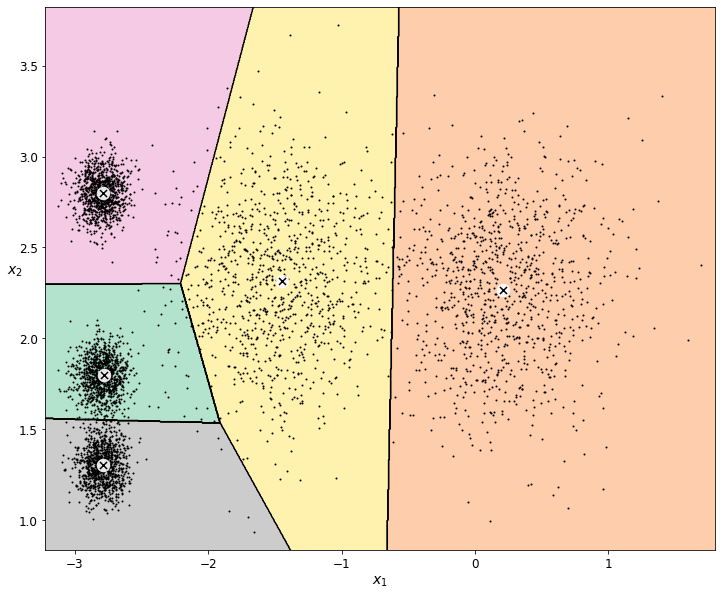

In [10]:
plt.figure(figsize=(12, 10))
plot_decision_boundaries(kmeans, X)
plt.show()

<h1> Hard Clustering vs Soft Clustering </h1>
Rather than abritraily choosing the closes cluster for each instance, which is called hard clustering, it might be better to measure the discnat of each observation to all 5 centroids. This is what the transofrm() method does

In [11]:
#the ijth element in the matrix is distance from the jth cluster
kmeans.transform(X)

array([[5.35551014e-01, 3.04706670e+00, 1.52582347e+00, 1.60929124e+00,
        1.23766581e-01],
       [5.36651952e-01, 3.23354872e+00, 1.53010852e+00, 1.76595804e+00,
        7.96175752e-02],
       [2.82983489e+00, 2.66317230e-01, 2.79564509e+00, 1.42785161e+00,
        2.98506819e+00],
       ...,
       [1.69571719e+00, 1.39503098e+00, 1.66355344e+00, 2.65015174e-01,
        1.92635203e+00],
       [9.98146350e-01, 3.04017896e+00, 2.99191770e-03, 1.42334944e+00,
        1.49705488e+00],
       [3.35696795e+00, 4.96906762e-01, 3.23787579e+00, 1.93275678e+00,
        3.53250068e+00]])

In [12]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)


array([[2.79007989, 0.34009906, 2.89787955, 1.47778986, 2.8783435 ],
       [5.78637356, 2.80221826, 5.84059162, 4.45466678, 5.83426665],
       [1.21911266, 3.29313158, 0.29433088, 1.69983808, 1.71116203],
       [0.7325327 , 3.21897679, 0.36710486, 1.56734156, 1.21637387]])

<h1> K-Means algorithm </h1>
THe k-means is on of the faste cluster algorithms, but lasoe one of the simplest. First ini k centros ranodmkly, k distance instances are chose randmol fomr the data set and the cetnroids are palced at their locations. Repeat until convergence or centroids stop moving. Assing each insstnace to the closte centroid, updates centorad to be the man of the instances that are assigne to them

In [13]:
#;ets run the alrgorithm for 1,2,and 3 iterations

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter4 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=4, random_state=1)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)
kmeans_iter4.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=4, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

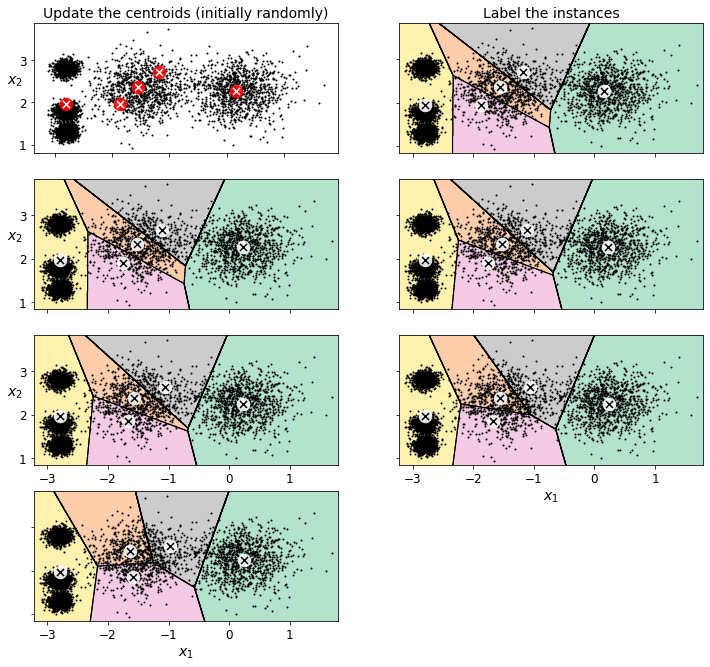

In [14]:
plt.figure(figsize=(12, 11))

plt.subplot(421)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(422)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(423)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(424)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(425)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(426)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.subplot(427)
plot_decision_boundaries(kmeans_iter4, X, show_ylabels=False)

plt.show()

<h1> K-means variability </h1>
in the oriignal kmeans algo, the centroids are just initilizaed randomly, and the algorithm simply runs a single iterations to gradually imporve the cetnrods as we saw above. However, one marojr problme with this approach is that if youn run kmean muiltiples, it can converge to differetn solutions

In [15]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

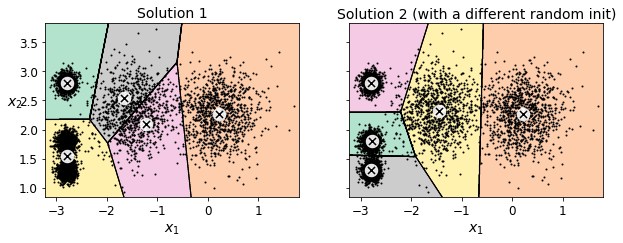

In [16]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

<h1> Inertia </h1>
To select the best model, we will need a way to evaluate a kmenas models performance. Unforunate;y, clustering is an upsupervised taks, so we do not have the targets. But at least we can measure the distance between each instance and its centroid 

In [17]:
kmeans.inertia_

634.0482787346584

In [21]:
#verify the ineratia is the sum of the squared distances between each training instance and its closest centroid
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

634.0482787346575

In [23]:
kmeans.score(X)

-634.0482787346575

<h1> Multiple initializations </h1>
So one approach to solve the variablity issue is to simply run kmeans multiples times with different randome initilzations, and select the solution that minimuzes the inertia. For axample, here athe interaits of the two base models shown in the previous figure:

In [24]:
print(kmeans_rnd_init1.inertia_)
print(kmeans_rnd_init2.inertia_)


672.4441277408815
634.0534718758729


In [25]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

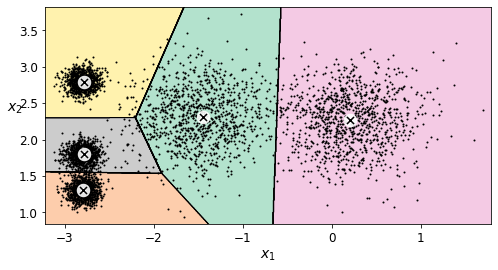

In [26]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

# Kmeans ++ 

* Take one centroid $c_{1}$ chose uniformly random from the dataset
* Tale a new center, $c_{i}$ chosing an instance $x_{i}$ with proability:
 * $D(x_{i})^2$ / / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$
 * where $D(x_{i})$ is te distance between the the instance $x_{i}$ and the closeste centroid that was already chosen
 * Repeat the previous step until all $k$ centroids have been chosen
 
The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce n_init considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set init="k-means++" (this is actually the default):

In [27]:
KMeans()

good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

634.0482787346584

# Accelerated K-means

Kmeans can be significantly acclerate by avoiding many unnecassry distance calculations by epxloiting the triangle in equlaity. 

In [28]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

146 ms ± 9.58 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [29]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

183 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini batch k-means

In [31]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [33]:
minibatch_kmeans.inertia_
#values is a little off from the kmeans before

660.2657012560401

In [34]:
#if the dataset is too big, you can us memmap
filename = "my_mnist.data"
m, n = 50000, 28*28
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

In [36]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [38]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [40]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
best_kmeans.score(X)


-644.0543388977032

In [41]:
%timeit KMeans(n_clusters=5).fit(X)

46.8 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

25.8 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
#lets plot the inrations ratioand the training time ratio between minibatch kmeans and regular kmeans
from timeit import timeit
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

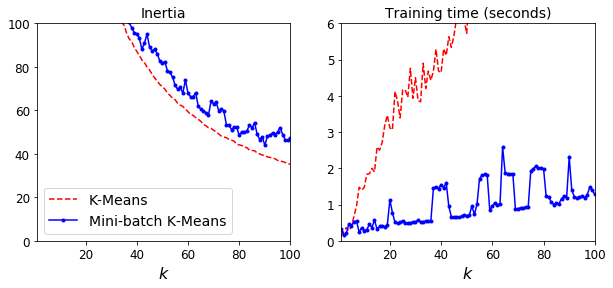

In [44]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Inertia", fontsize=14)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Training time (seconds)", fontsize=14)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])
#plt.legend(fontsize=14)

plt.show()

### Finding the optimale number of clusters

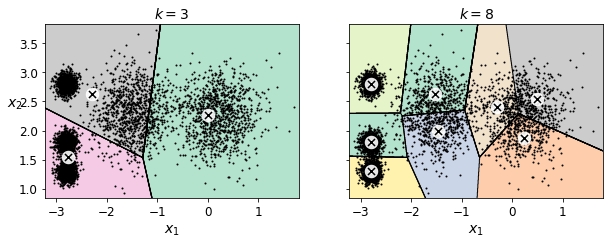

In [46]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

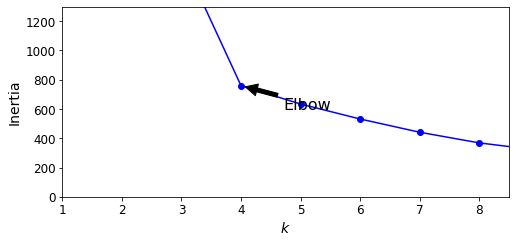

In [47]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

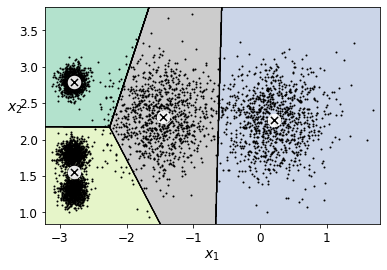

In [48]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

### We can also examine the silhoutte score
Equal to $\frac{b-a}{max(a,b)}$
a is the mean distance to the other instances in the smae cluister
b is the mean nearest cluster distance
varies betwwen -1 and + 1
+1 mena the instnace is well insides its own cluster
0 means it is close to a cluster boundary
-1 means that the instance may have been assigned to the wrong cluster

In [49]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)


0.32470059878120267

In [50]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

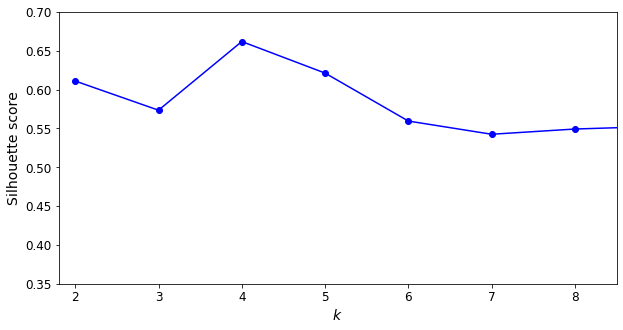

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.35, 0.7])
plt.show()

As you can see this visulization is much richer than the previous one, 4 seems good, but couljd be just as good

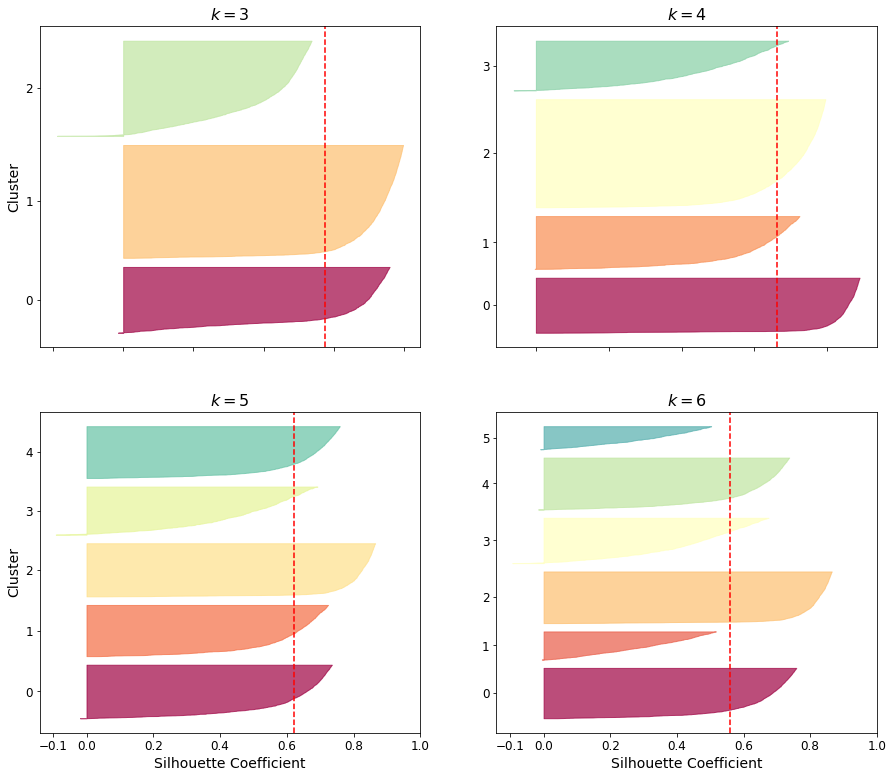

In [56]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(15, 13))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### Limits of K-means

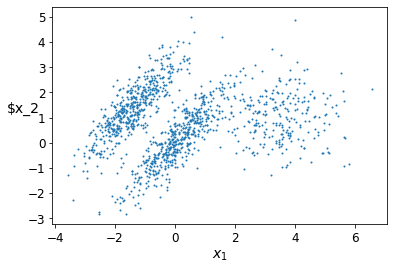

In [57]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

In [58]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

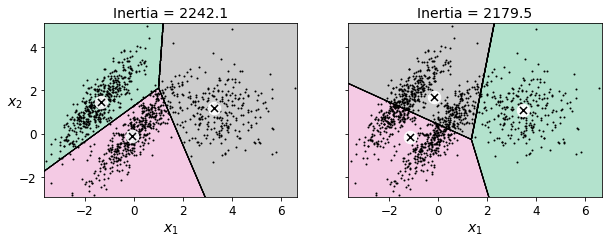

In [60]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)
plt.show()

### Using clustering for pre processing

In [62]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
log_reg.score(X_test, y_test)


0.9666666666666667

Now use k-means as a preprocessing step. We will creae a pipline that will first cluster the trianing set into 5- clusters and replace the iamges with their distances to the 5- clusters, then apply a logistic regresion model

In [64]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [65]:
pipeline.score(X_test, y_test)

0.9822222222222222

In [66]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.0s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] ............................. kmeans__n_clusters=5, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=22, total=   0.2s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   0.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=44 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=61, total=   0.8s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   0.7s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   0.7s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.6s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.6s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.6s
[CV] kmeans__n_clusters=63 ...........................................
[CV] ............................ kmeans__n_clusters=63, total=   0.6s
[CV] kmeans__n_clusters=63 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=80, total=   0.8s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   0.7s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.7s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.7s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.7s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   0.7s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   0.8s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   0.8s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
      

In [67]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [68]:
grid_clf.best_score_

0.9665924276169265

<h1> Clustering for semi-supervised learning </h1>

In [69]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8266666666666667

In [70]:
#get distances for each observation from center
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

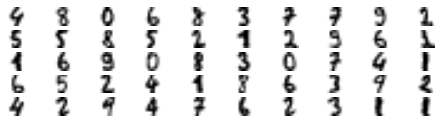

In [71]:
#lets plot and label them manually
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [72]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labels instances, but isntead of ebign compelte random istances, each of them is a represenative images of its cluster. Lets see of the performaces is any better:

In [73]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

What is if tacked the labels to all other instances in the same clsuter?

In [77]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [80]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test,y_test)

0.9288888888888889

We got a tiny little accuracy boost, but we should ahve probably propagates the labels only to the instances closest to the centroid, because by propogating to the full clsuter, we have certainly included some outliers. Lets only propagate the labes tot eh 20th percentile closest to the centroid

In [92]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [93]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)


0.9422222222222222

# DBSCAN

In [94]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [95]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [96]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

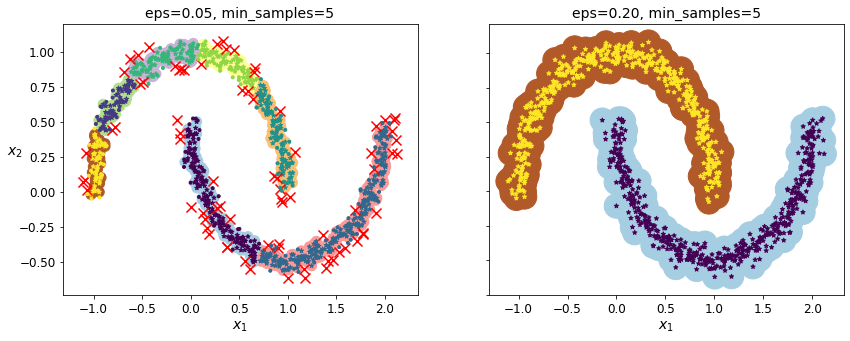

In [97]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [98]:
dbscan = dbscan2

In [99]:
#compated to kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

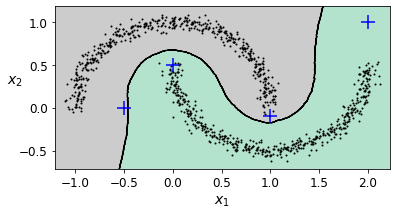

In [100]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [101]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other clustering algos
### Spectral Clustering

In [102]:
from sklearn.cluster import SpectralClustering
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [103]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [104]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

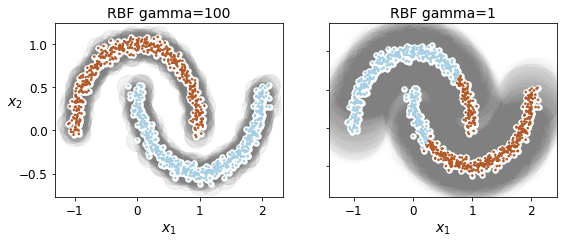

In [105]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

# Gaussian Mixutres

In [106]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [107]:
#lets train a gaussian mixture model on the previous dataset
from sklearn.mixture import GaussianMixture

In [108]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [109]:
gm.weights_

array([0.20965228, 0.4000662 , 0.39028152])

In [110]:
gm.means_

array([[ 3.39909717,  1.05933727],
       [-1.40763984,  1.42710194],
       [ 0.05135313,  0.07524095]])

In [111]:
gm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]]])

In [112]:
gm.converged_


True

In [113]:
gm.n_iter_


4

In [114]:
#you can sample new instances from the model, generative learning
X_new, y_new = gm.sample(6)
X_new

array([[ 2.95400315,  2.63680992],
       [-1.16654575,  1.62792705],
       [-1.39477712, -1.48511338],
       [ 0.27221525,  0.690366  ],
       [ 0.54095936,  0.48591934],
       [ 0.38064009, -0.56240465]])

In [115]:
y_new

array([0, 1, 2, 2, 2, 2])

In [116]:
gm.score_samples(X)


array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

Let's check that hte PDF intergrates to 1 over the whole space. We just take a large square aorund teh clusters and chop it into a grid of tiny squares, then we compue the approximae probabiltiy that the instances will be generated in each tiny square (by multiplying the PDF at one cornver of the tiny square by the area of the square) and fianlly summiing all these probabilites. The results is very close to 1:

In [126]:
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()


0.9999999999217851

In [127]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

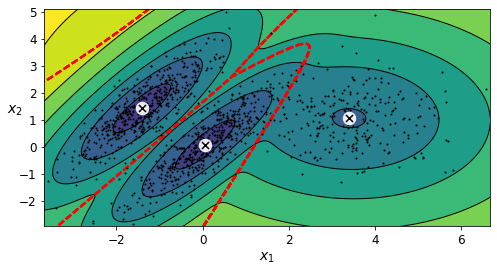

In [128]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

you can impose constraints on the covariance matrices that the alogrithm looks for by setting the covariance_type hyperparameter
* "full' no constraint all clusters can take on any ellipsodial shape
* 'tied' all clusters must be sphericial, byt they can have different diameters
* 'sphericial' all clusters must be spherical, but they can have different diamters
* 'diag; cluster can take on any ellipsodial shape of any size, but the ellipsoids axes must be parralele to the axes

In [129]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [138]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

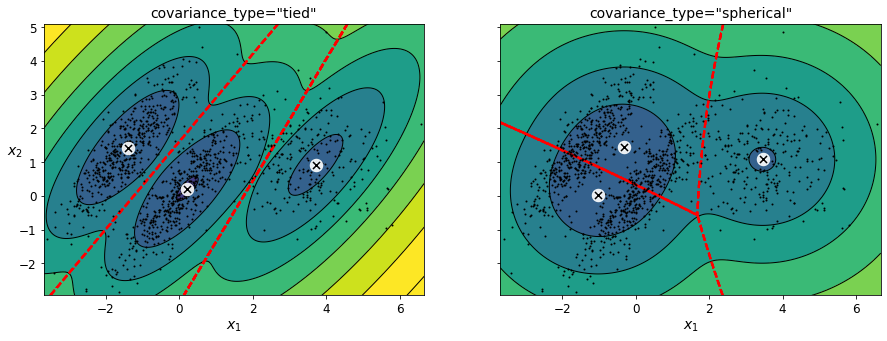

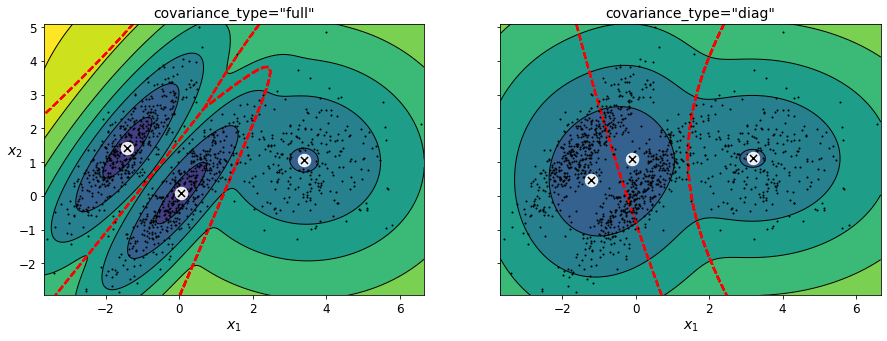

In [140]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
compare_gaussian_mixtures(gm_full, gm_diag, X)

plt.show()

### Anomaly Detection using Gaussian Mixtures

Gaussain mixtures can be used for anaomly detection. Instances located in low-density regions can be conisdered anomalies. You must define what density threshold to use. For, example in a manufacturing copmany, that tried to detect defective products, the ratio of defective products is ually well known. Say it is equal to 4% then you can set the denstiy threshold to be the value that results in having 4% of the instances in areas below that threshold density

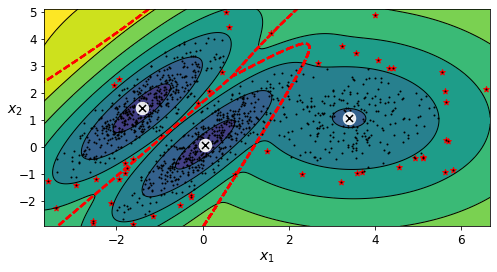

In [142]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Model selection
We cannot use the criteria of the silhouette because they both assume that they clusters are spherical. Instead, we can try to find the model that minimizes a theoretical criterion such as the bayesian information criterion (BIC) or the Akaike Information Criterion (AIC)

$BIC = log(m)p - 2log(\hat{L})$

$AIC = 2p - 2log(\hat{L})$

* m is the number of instances
* p is the number of parameters leanred by the model
* $\hat{L}$ is the maximized value of the likelihood function of the model. This is the conditional proability of the observed data X, givne the model and its optimized parameters. Data given model!!!

Both BIC and AIC penalize models that have more parameters to learn, and reward models that fit the data well

In [143]:
print(gm.bic(X))
print(gm.aic(X))

8189.74345832983
8102.518178214792


In [144]:
#try to compute manually
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

There's one weight per cluster, but the sum must euqal to 1, so we have one degree of freedome, hence the -1

In [145]:
#lets train the mdoels with varios values of k
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [146]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

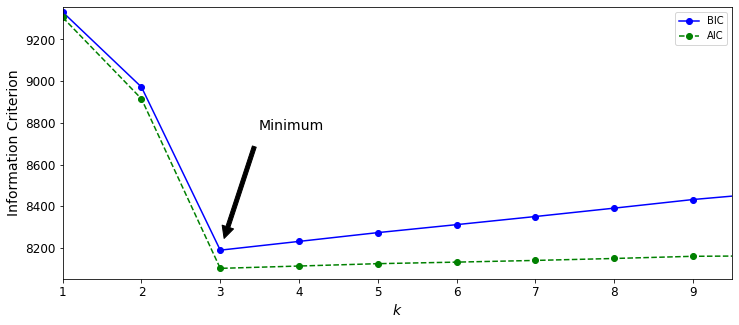

In [149]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Let's search for the best combination of values for both the number of clusters and the covariance_type hyperparameter

In [151]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [152]:
print(best_k)
print(best_covariance_type)

3
full


# Variational Bayesian Gaussian Mixtures
Rather than manually searching for the optimal number of clusters, it is possible to use instead the BayesianGassuainMicute class which is cpaable of viing uqla or close to zerop to unncesary clsuters. Just set the number of components to a value that you beleive is greater than the opitmal number of clusters, and the alo will eliminate the unncessary clusters automatically.

In [153]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [158]:
bgm.covariances_

array([[[ 7.18174365e-01,  8.19657713e-01],
        [ 8.19657713e-01,  1.23961080e+00]],

       [[ 1.12952552e+00, -1.89441962e-03],
        [-1.89441962e-03,  9.35514115e-01]],

       [[ 6.49737954e-01,  7.29168497e-01],
        [ 7.29168497e-01,  1.16321806e+00]],

       [[ 1.97682967e+00,  2.04716652e-01],
        [ 2.04716652e-01,  7.57490145e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]],

       [[ 1.97682979e+00,  2.04716625e-01],
        [ 2.04716625e-01,  7.57490141e-01]]])

In [159]:
bgm.weights_

array([3.95095317e-01, 2.05162685e-01, 3.99662331e-01, 7.24246329e-05,
       6.58404122e-06, 5.98549202e-07, 5.44135638e-08, 4.94668762e-09,
       4.49698874e-10, 4.08817159e-11])

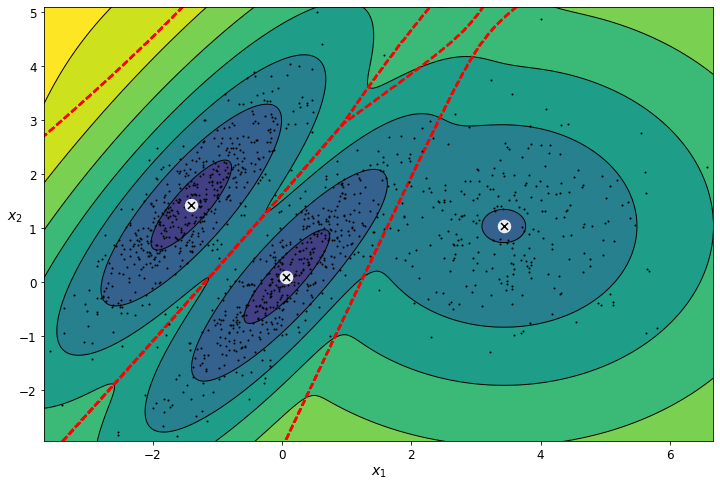

In [161]:
plt.figure(figsize=(12, 8))
plot_gaussian_mixture(bgm, X)
plt.show()

In [169]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_medium = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10, random_state=42)

bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_medium.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [163]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [164]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

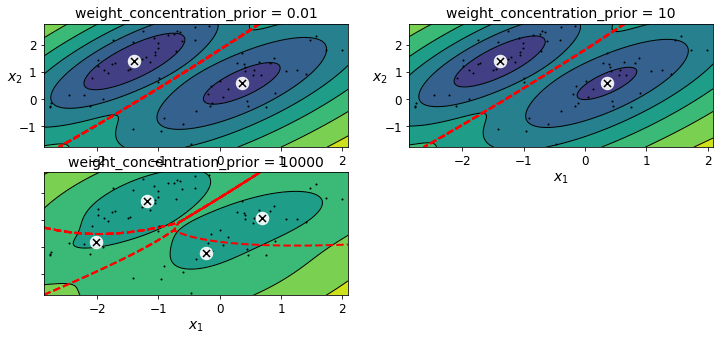

In [171]:
plt.figure(figsize=(12, 5))

plt.subplot(221)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(222)
plot_gaussian_mixture(bgm_medium, X[:nn])
plt.title("weight_concentration_prior = 10", fontsize=14)

plt.subplot(223)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

Note: the face that you see only three regions in the right plot, although there are 4 centroids is not a bug. The weight of the top right cluster is much larger than the weight of the lower_right cluster, so the probablitiy that any given point in this region belogns tot eh top right lcuster is greater than the prob that it belongs to the lower right cluster!

In [172]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

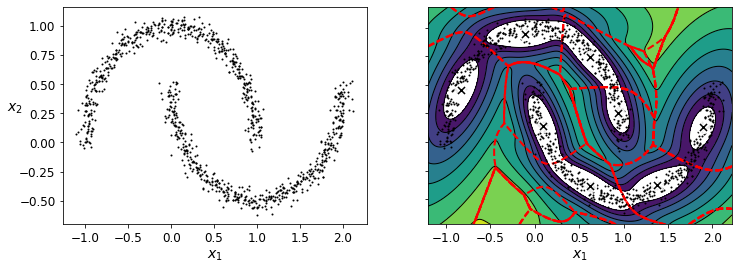

In [175]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

plt.show()

# LIKELIEHOOD FUNCTION

In [176]:
from scipy.stats import norm

In [191]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1) / (xx[1] - xx[0])

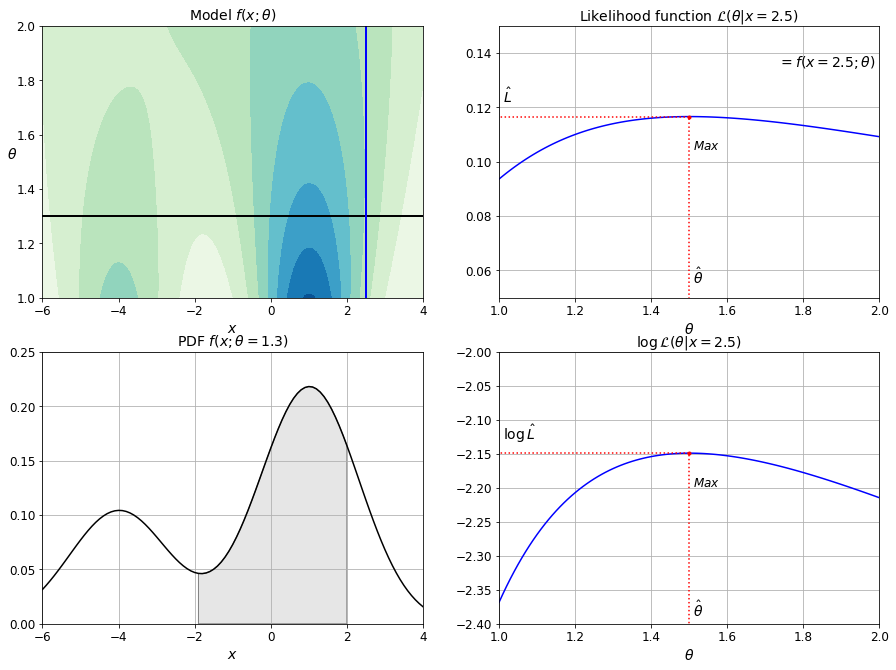

In [198]:
from matplotlib.patches import Polygon

plt.figure(figsize=(15, 11))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.show()

# Exercise Solutions
# 9

In [202]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [203]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

import time
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))


Training took 3.87s


In [204]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9492

In [205]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

Lets see how long training retakes after passing in X_train reduces

In [206]:
X_train_reduced.shape

(60000, 154)

In [207]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 8.49s


Why did training time take slower? Recall that dimension reduction does not always lead to faster training time, it depends on the dataset, the model, and the training algo. If you try a softmax classifier, instead of a randome forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we wll do this in as econd, byt fist check out the preciision of the new random foest classifer.


In [208]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

It's expected for accuracy to decrease after performing dimension reduction techniques, 

But lets compare with softmax

In [211]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training tme took {:.2f}s".format(t1-t0))

Training tme took 13.23s


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Softmax reg took much lgnoer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But thats not what we are intereested in right now, we want to see how much PCA can help softmax regression.

In [212]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [213]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 4.44s


In [214]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance,which might be a resonable price to pay for a 4x speedup, depending on the application. So there you have it, PCA can give you  a formidable speedup, but not always

# 10.

UseT-SNE to reduce the MNIST dataset shown to two dimensions


In [215]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [216]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

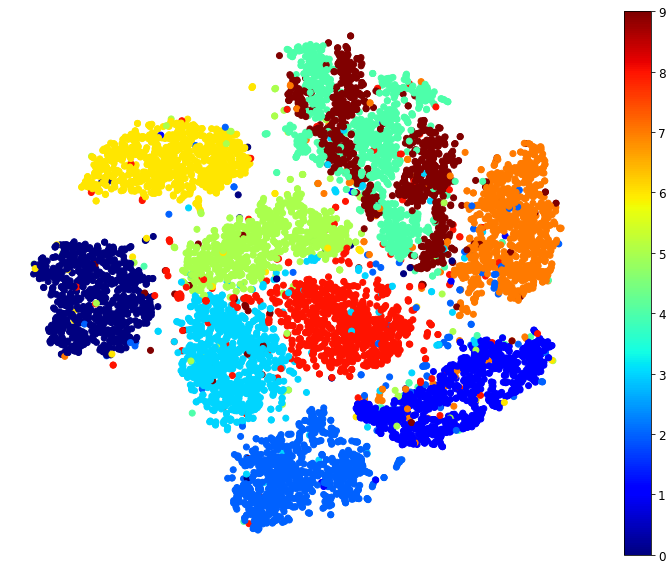

In [217]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

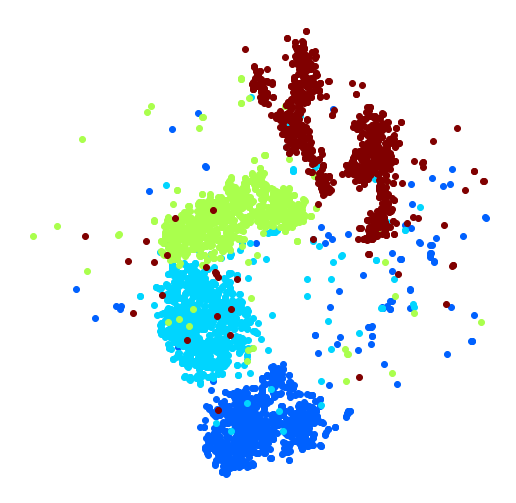

In [218]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5,9):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Clean up image showing digits, 2,3,5,9

In [219]:
idx = (y == 2) | (y == 3) | (y == 5) | (y==9) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

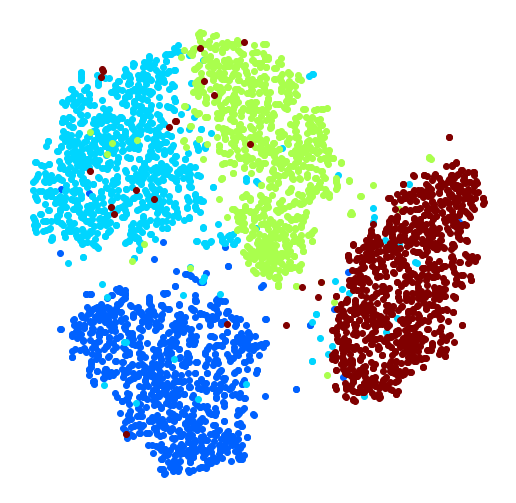

In [220]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5,9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [221]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

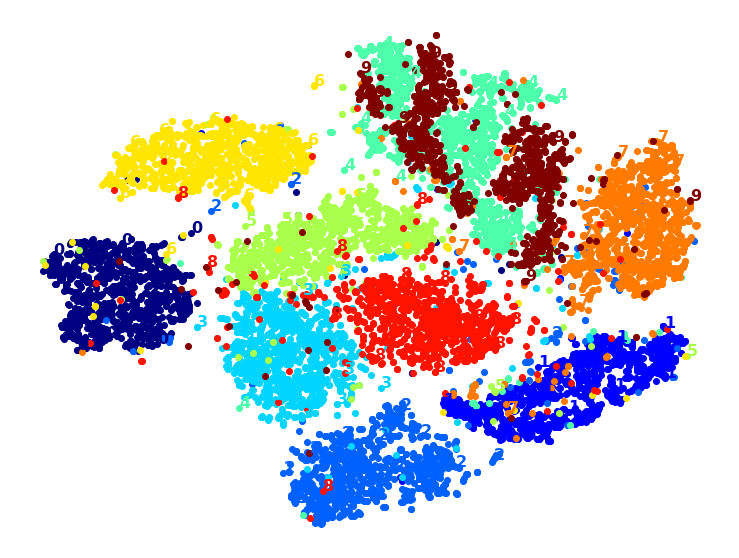

In [222]:
plot_digits(X_reduced, y)

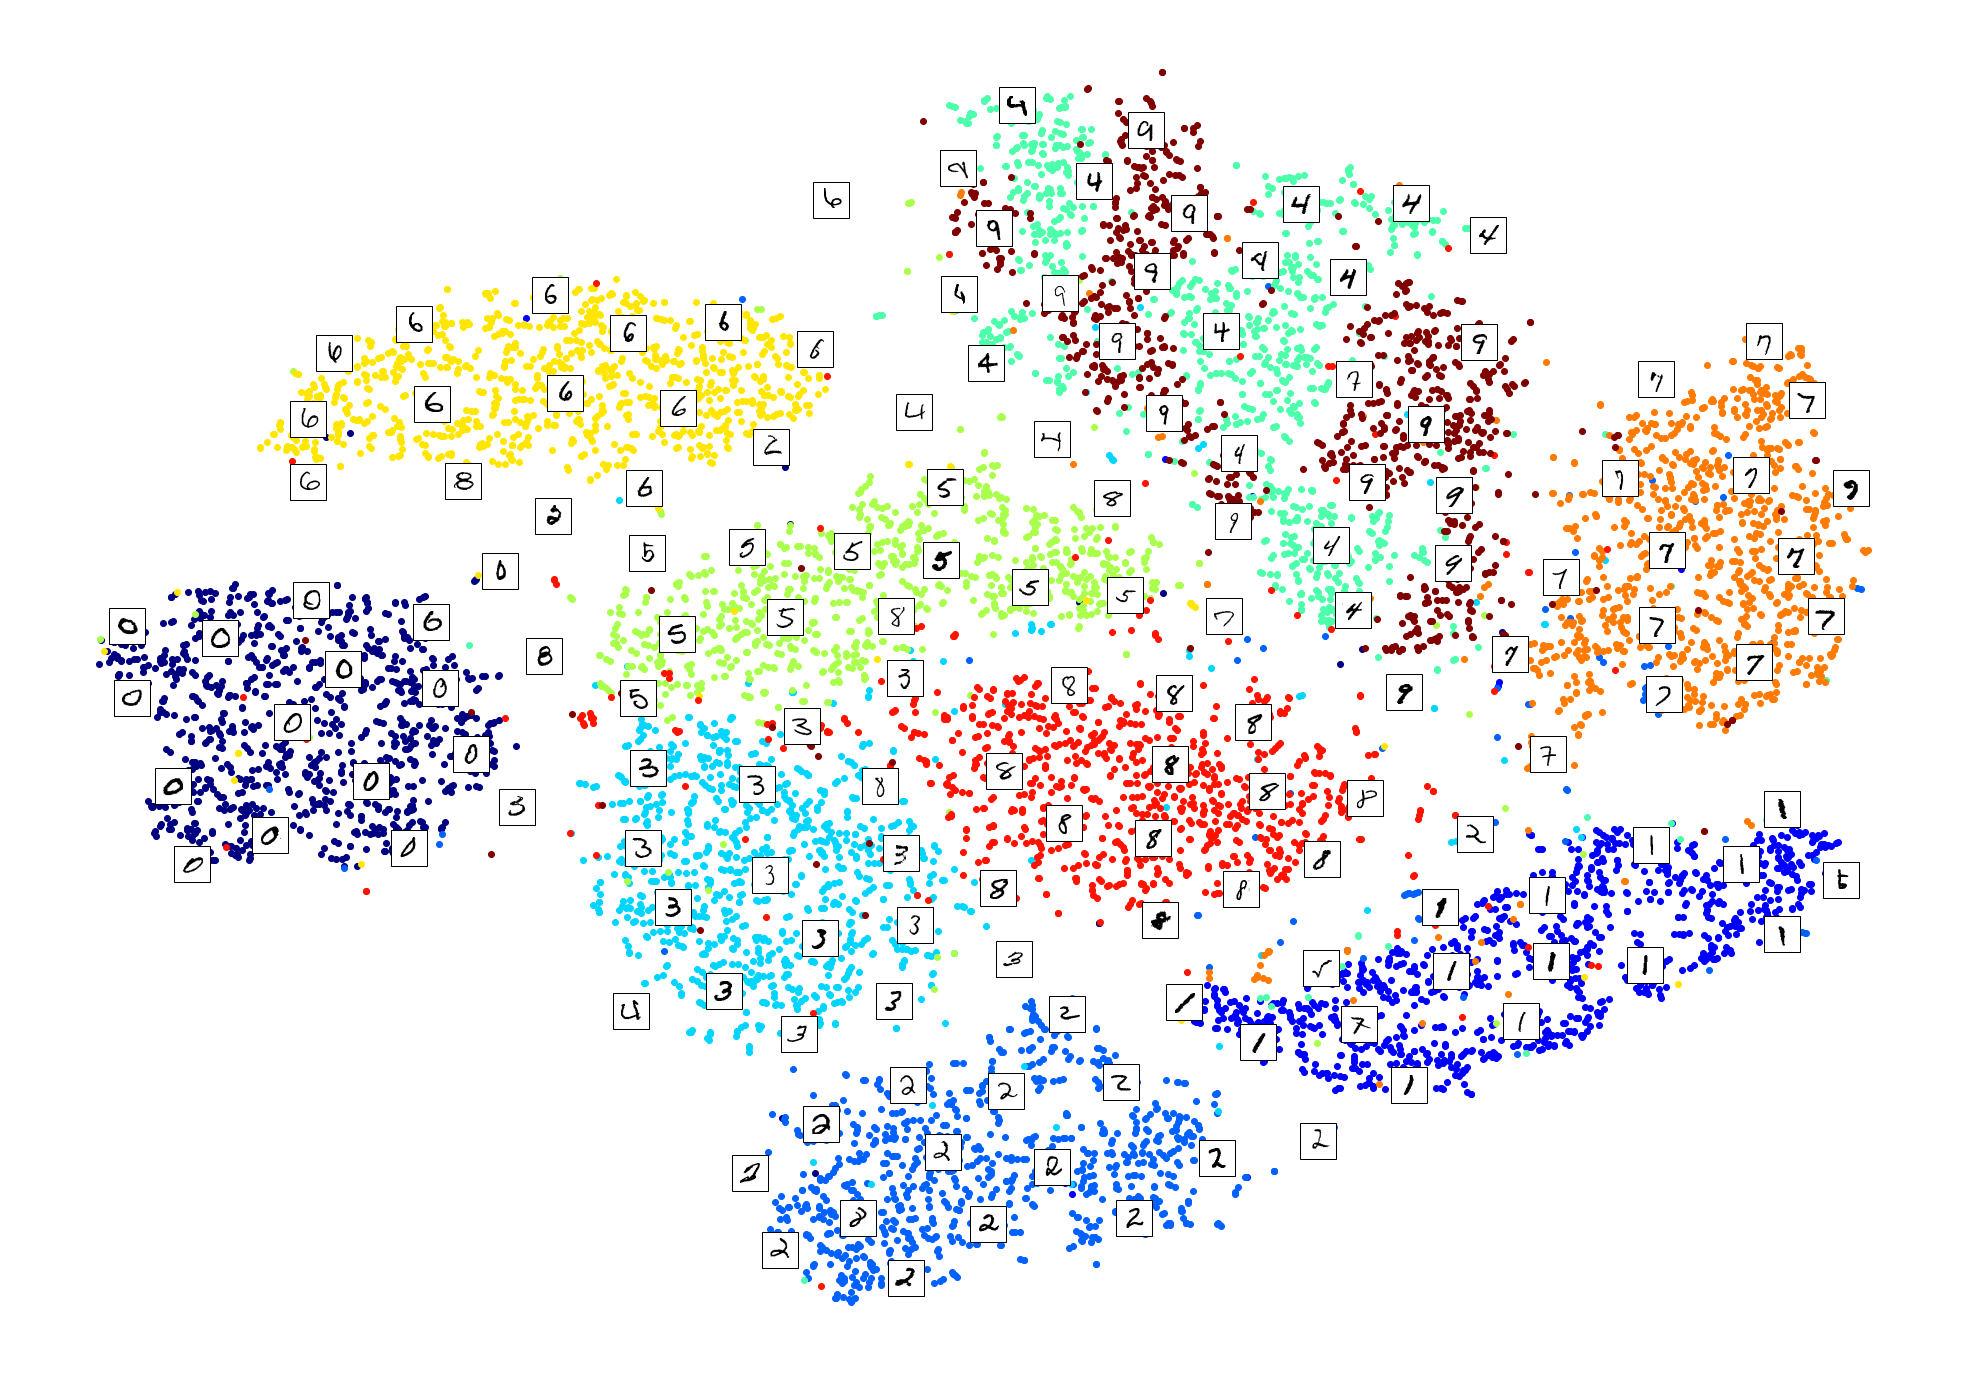

In [223]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

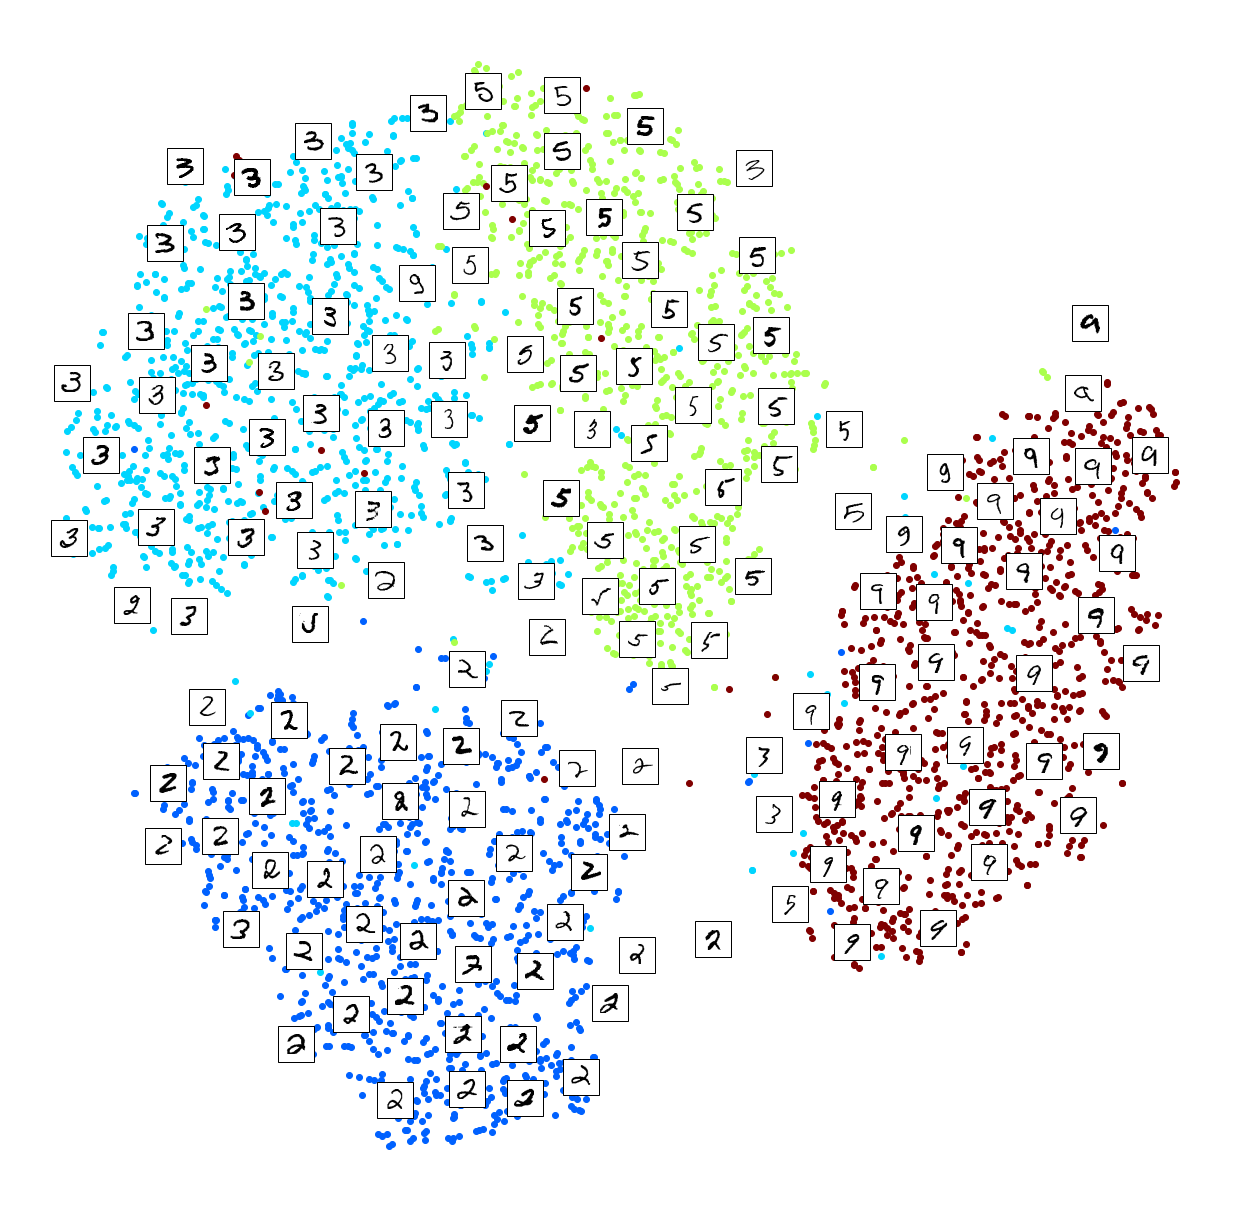

In [224]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA took 0.3s.


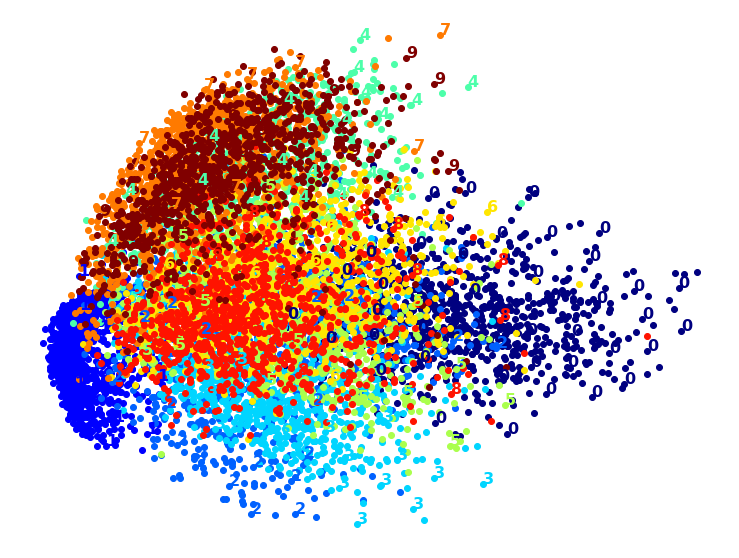

In [225]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()